In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, Birch
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
df = pd.read_csv('data/zscore_norm_data.csv')
df.set_index('Unnamed: 0', inplace=True)
df.rename_axis('Ticker', inplace=True)
df.head()

2022-07-18  2022-07-19  2022-07-20  2022-07-21  2022-07-22  \
Ticker                                                               
III.L          0.0   -0.785353   -0.672737    0.180115    0.558656   
ADM.L          0.0   -2.536109   -2.159671   -1.465230   -1.510831   
AAF.L          0.0    1.635091    0.969205    1.073422    0.597371   
ALW.L          0.0   -0.622714   -0.259381    0.117792   -0.092458   
AAL.L          0.0   -1.311536   -0.816264   -1.049739   -0.711896   

        2022-07-25  2022-07-26  2022-07-27  2022-07-28  2022-07-29  ...  \
Ticker                                                              ...   
III.L     0.040175   -0.153359   -0.199763    0.187659    0.333004  ...   
ADM.L    -1.572777   -0.974800   -0.148738    0.484290    0.670425  ...   
AAF.L     0.759242    1.903814    1.853999    0.322964   -0.863307  ...   
ALW.L     0.053369   -0.310505   -0.234843    0.041945    0.032392  ...   
AAL.L    -0.118151    0.964515    0.843063    1.316941    1.435245  ...   

        2024-12-10  2024-12-12  2024-12-13  2024-12-18  2024-12-19  \
Ticker                                                               
III.L     2.588298    2.560196    2.574297    2.550376    2.507802   
ADM.L     0.318760    0.293430    0.290483    0.283715    0.304061   
AAF.L    -0.917304   -0.915736   -0.906702   -0.874515   -0.872692   
ALW.L     0.120600    0.115943    0.121572    0.097466    0.106894   
AAL.L    -0.500607   -0.479048   -0.505832   -0.510220   -0.529248   

        2024-12-20  2024-12-23  2024-12-24  2024-12-27  2024-12-30  
Ticker                                                              
III.L     2.490774    2.499012    2.515312    2.547772    2.551437  
ADM.L     0.305384    0.314251    0.318277    0.315926    0.320369  
AAF.L    -0.871005   -0.848753   -0.825203   -0.805893   -0.795751  
ALW.L     0.120337    0.125632    0.117213    0.103647    0.115960  
AAL.L    -0.539001   -0.539067   -0.530580   -0.539015   -0.541961  

[5 rows x 613 columns]

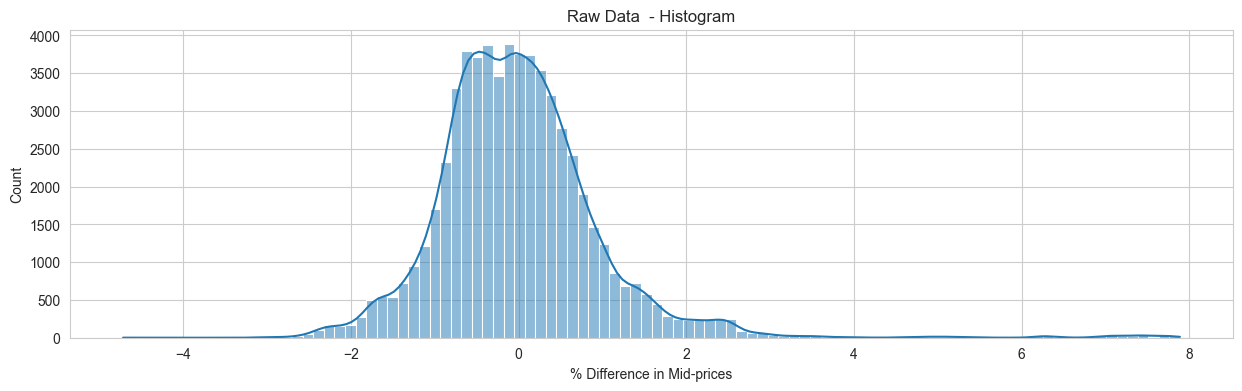

In [3]:
plt.figure(figsize=(15, 4))
sns.histplot(df.values.flatten(), bins=100, kde=True)
plt.title(f'{"Raw Data"}  - Histogram')
plt.xlabel("% Difference in Mid-prices")
plt.show()

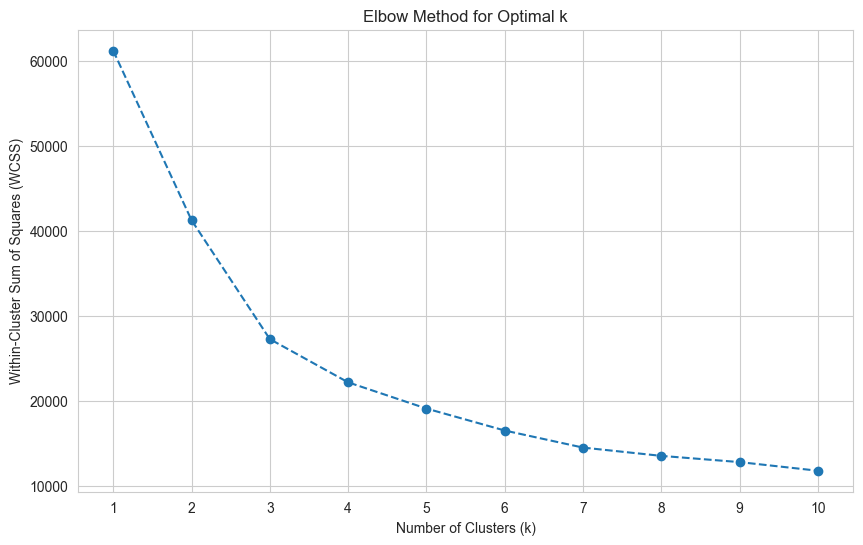

In [4]:
# Implement the Elbow Method
wcss = []  # Within-cluster sum of squares
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method results
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(k_range)
plt.grid(True)

In [5]:
# Choose optimal k based on the elbow (assume 4 here)
optimal_k = 5

# Fit clustering models
kmeans = KMeans(n_clusters=optimal_k, random_state=42).fit(df)
gmm = GaussianMixture(n_components=optimal_k, random_state=42).fit(df)
dbscan = DBSCAN(eps=2.5, min_samples=3).fit(df)
agglo = AgglomerativeClustering(n_clusters=optimal_k).fit(df)
birch = Birch(n_clusters=optimal_k).fit(df)

# Step 5: Evaluation Metrics
def evaluate_clustering(data, labels, name):
    if len(set(labels)) <= 1:
        print(f"{name} clustering resulted in 1 or fewer clusters. Skipping metrics.\n")
        return
    print(f"Results for {name}:")
    print(f"Silhouette Score (Higher is better): {silhouette_score(data, labels):.3f}")
    print(f"Davies-Bouldin Index (Lower is better): {davies_bouldin_score(data, labels):.3f}")
    print(f"Calinski-Harabasz Score (Higher is better): {calinski_harabasz_score(data, labels):.3f}\n")

evaluate_clustering(df, kmeans.labels_, "KMeans")
evaluate_clustering(df, gmm.predict(df), "GMM")
evaluate_clustering(df, dbscan.labels_, "DBSCAN")
evaluate_clustering(df, agglo.labels_, "Agglomerative")
evaluate_clustering(df, birch.labels_, "Birch")

# Step 6: Visualize stock trends by cluster
# def plot_clusters_trend(df, labels, title_prefix):
#     df_copy = df.copy()
#     df_copy['Cluster'] = labels
#     for cluster_id in sorted(df_copy['Cluster'].unique()):
#         cluster_members = df_copy[df_copy['Cluster'] == cluster_id].drop(columns='Cluster')
#         plt.figure(figsize=(14, 5))
#         for i in range(len(cluster_members)):
#             plt.plot(cluster_members.columns, cluster_members.iloc[i], alpha=0.4)
#         plt.title(f"{title_prefix} - Cluster {cluster_id} Trends")
#         plt.xticks([])
#         plt.tight_layout()
#         plt.show()

from matplotlib.ticker import MaxNLocator

# Step 6: Visualize stock trends by cluster
def plot_clusters_trend(df, labels, title_prefix, tick_interval=50):
    """
    Plots stock trends for each cluster with xticks shown at specified intervals.

    Parameters:
        df (pd.DataFrame): DataFrame of stock data with dates as columns.
        labels (array-like): Cluster labels for each row in df.
        title_prefix (str): Title prefix for each plot.
        tick_interval (int): Interval for x-axis ticks (default=5).
    """
    df_copy = df.copy()
    df_copy['Cluster'] = labels
    
    for cluster_id in sorted(df_copy['Cluster'].unique()):
        cluster_members = df_copy[df_copy['Cluster'] == cluster_id].drop(columns='Cluster')
        plt.figure(figsize=(14, 5))
        
        for i in range(len(cluster_members)):
            plt.plot(cluster_members.columns, cluster_members.iloc[i], alpha=0.4)
        
        plt.title(f"{title_prefix} - Cluster {cluster_id} Trends")
        plt.xlabel('Date')
        
        # Set xtick intervals
        ax = plt.gca()
        ax.xaxis.set_major_locator(MaxNLocator(integer=True, prune=None, nbins='auto'))
        xticks = range(0, len(cluster_members.columns), tick_interval)
        plt.xticks(xticks, [cluster_members.columns[i] for i in xticks], rotation=45)
        
        plt.tight_layout()
        plt.show()

Results for KMeans:
Silhouette Score (Higher is better): 0.202
Davies-Bouldin Index (Lower is better): 1.139
Calinski-Harabasz Score (Higher is better): 50.896

Results for GMM:
Silhouette Score (Higher is better): 0.202
Davies-Bouldin Index (Lower is better): 1.139
Calinski-Harabasz Score (Higher is better): 50.896

DBSCAN clustering resulted in 1 or fewer clusters. Skipping metrics.

Results for Agglomerative:
Silhouette Score (Higher is better): 0.184
Davies-Bouldin Index (Lower is better): 1.172
Calinski-Harabasz Score (Higher is better): 49.618

Results for Birch:
Silhouette Score (Higher is better): 0.184
Davies-Bouldin Index (Lower is better): 1.172
Calinski-Harabasz Score (Higher is better): 49.618



# KMeans

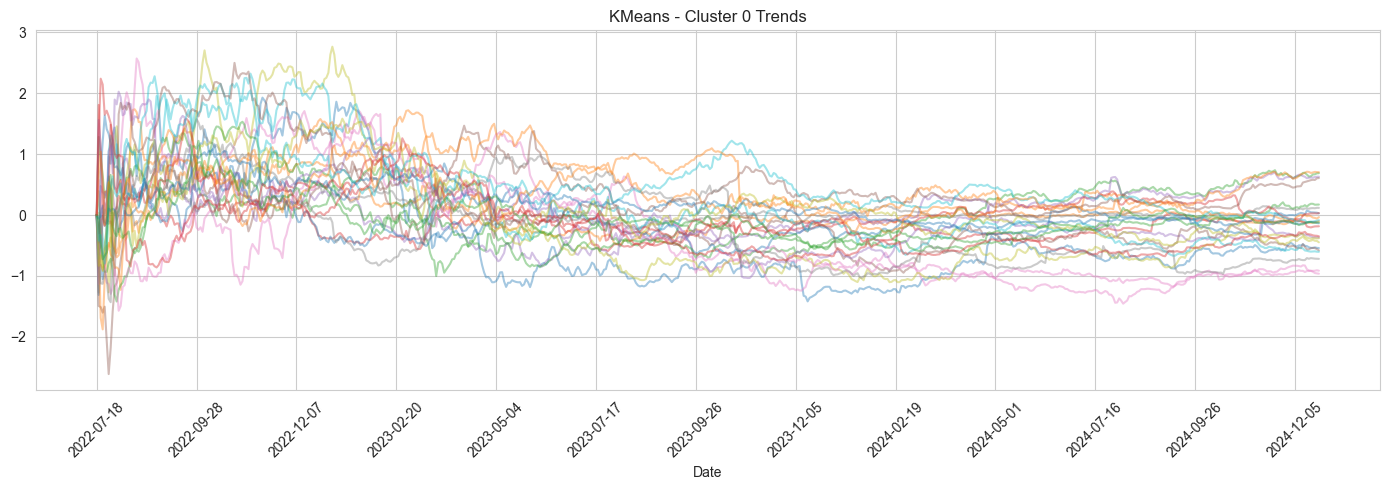

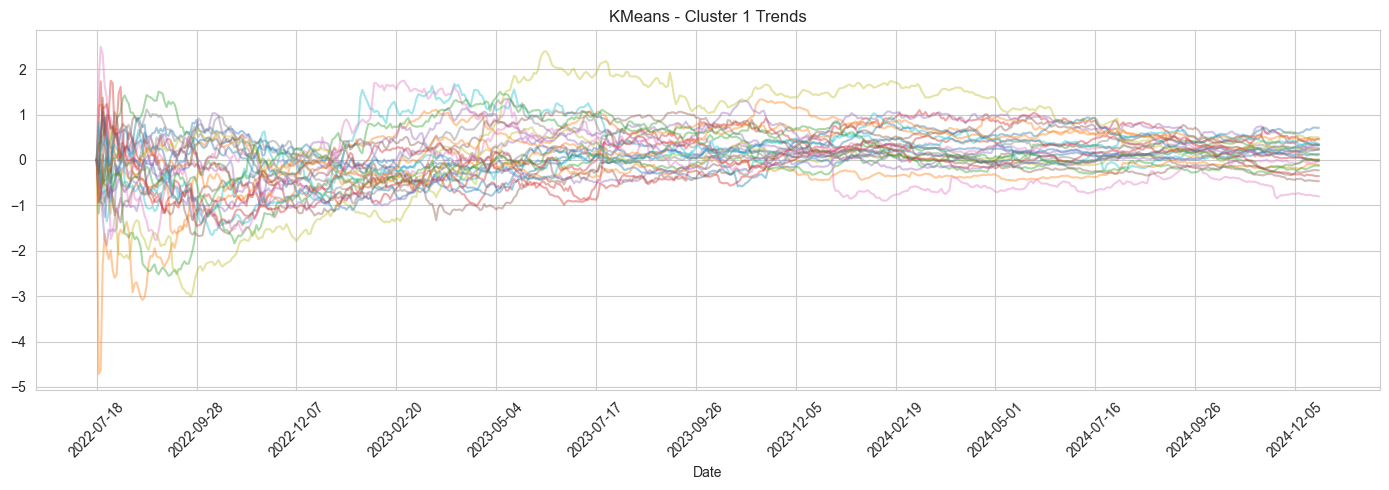

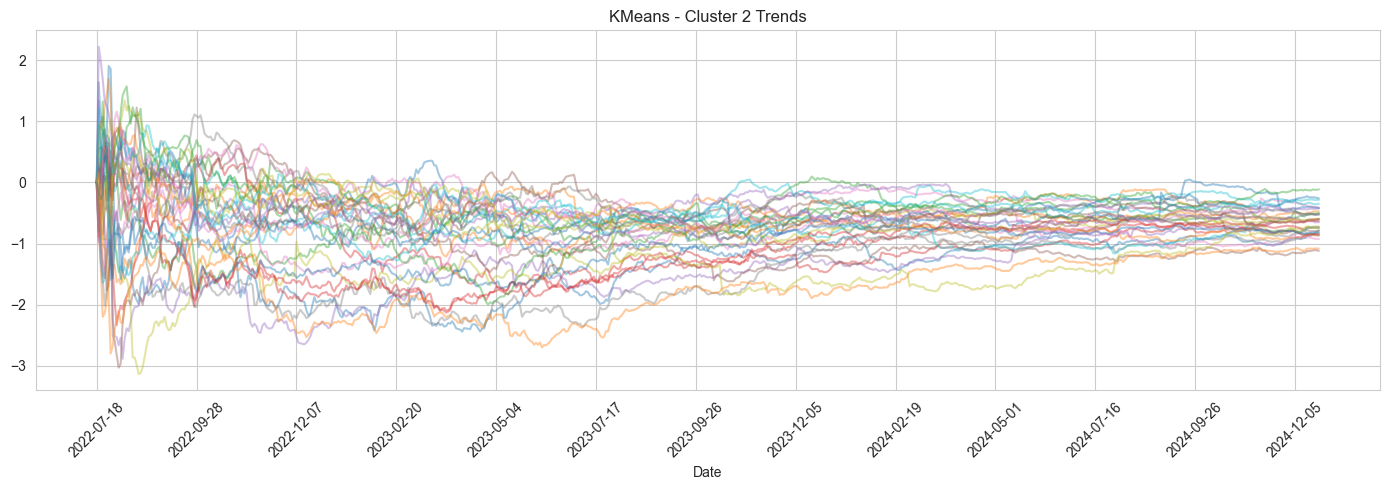

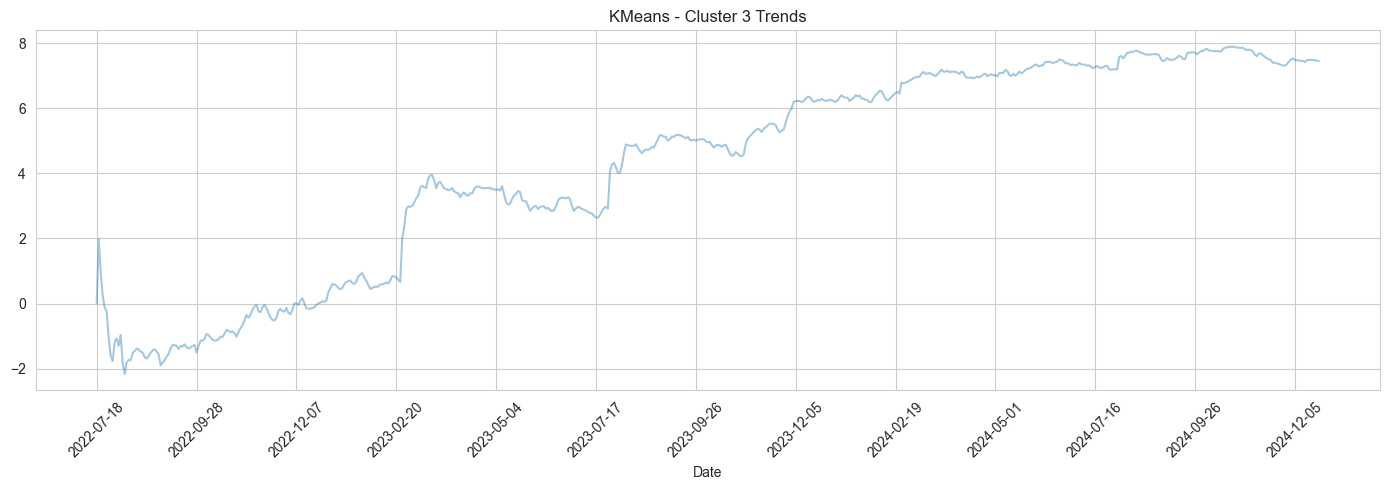

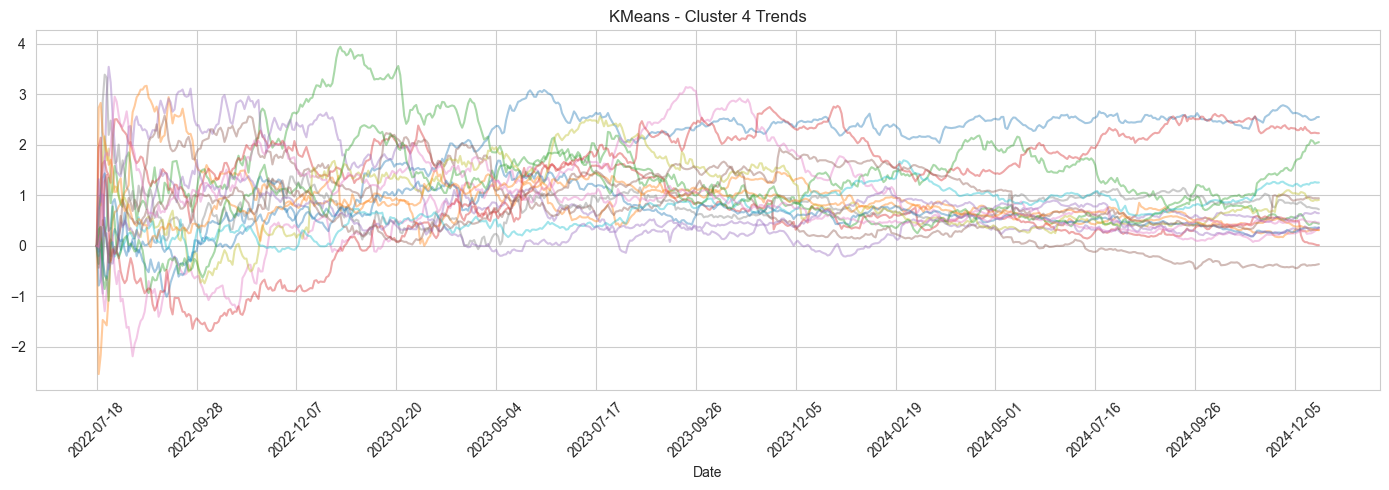

In [6]:
# Example: Visualize KMeans clusters
plot_clusters_trend(df, kmeans.labels_, "KMeans")

# Agglomerative

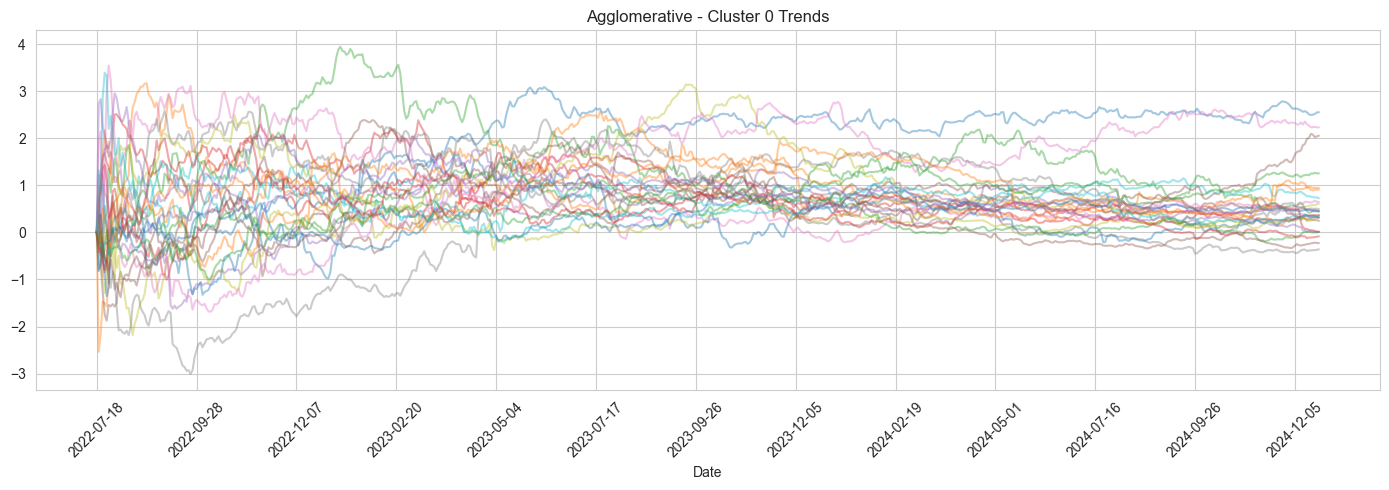

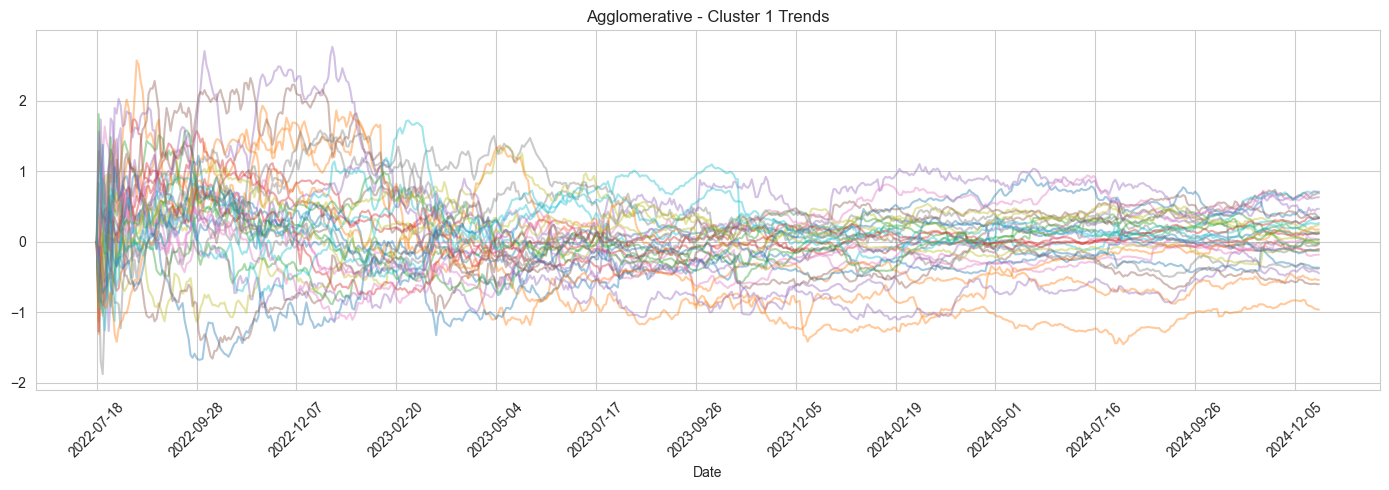

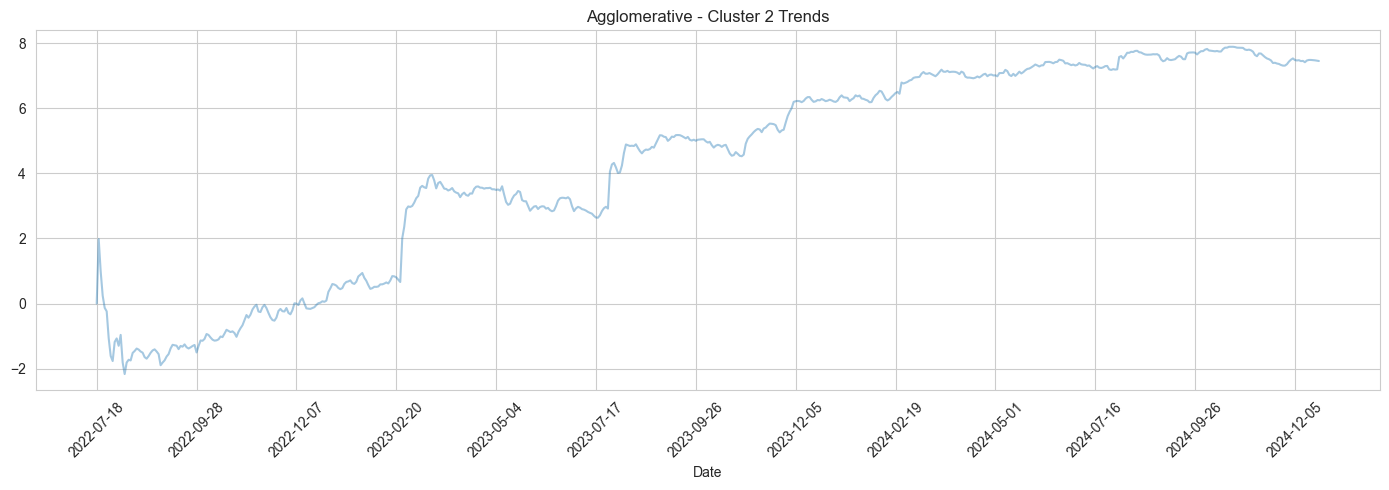

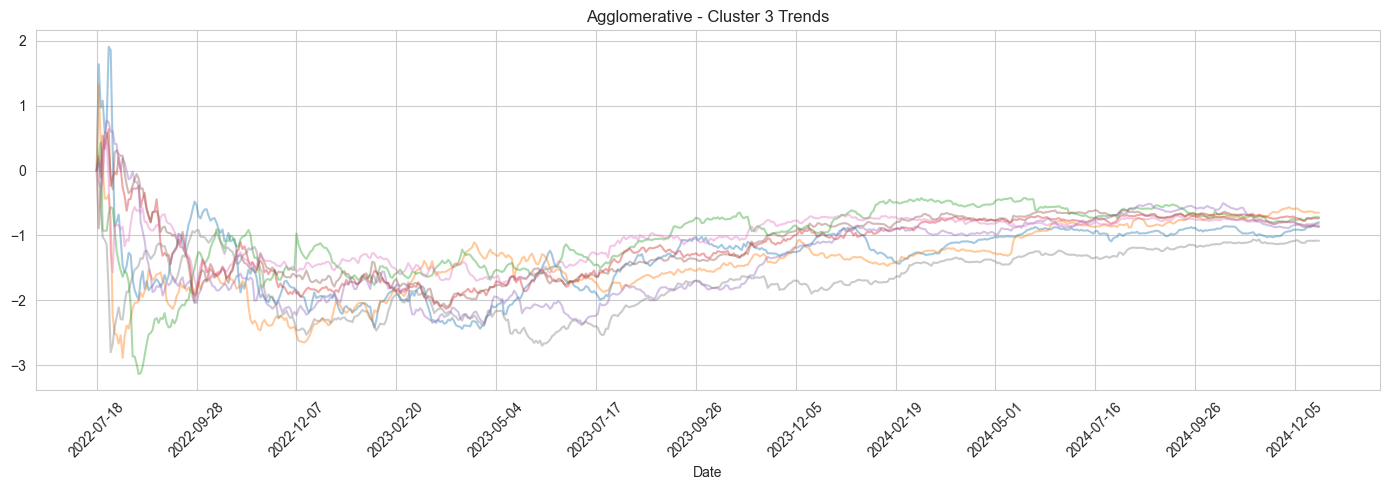

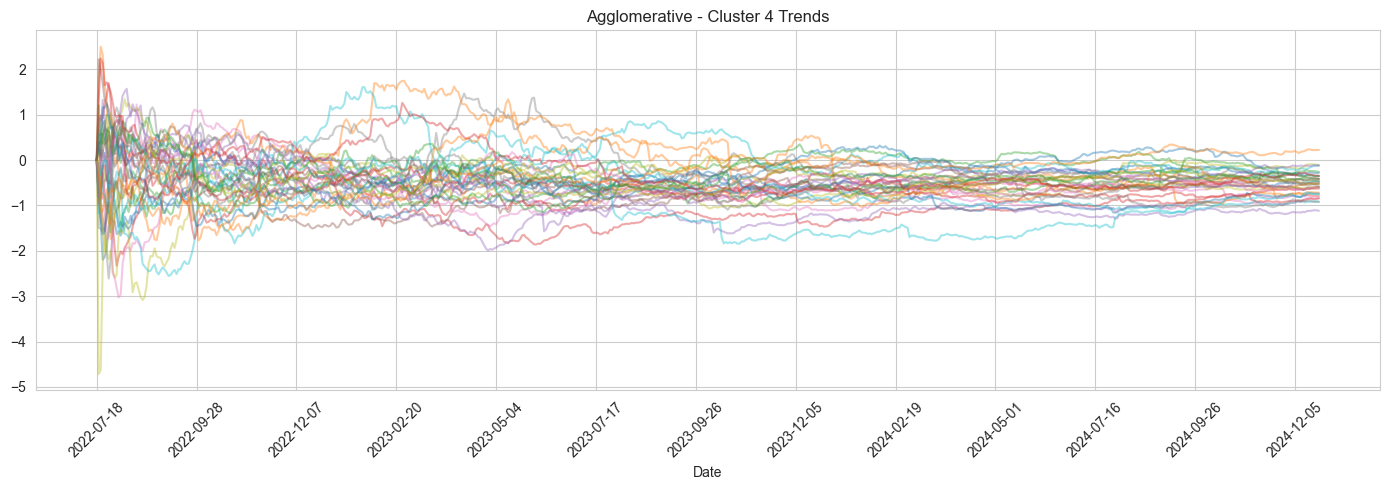

In [7]:
# Example: Visualize KMeans clusters
plot_clusters_trend(df, agglo.labels_, "Agglomerative")

# GMM

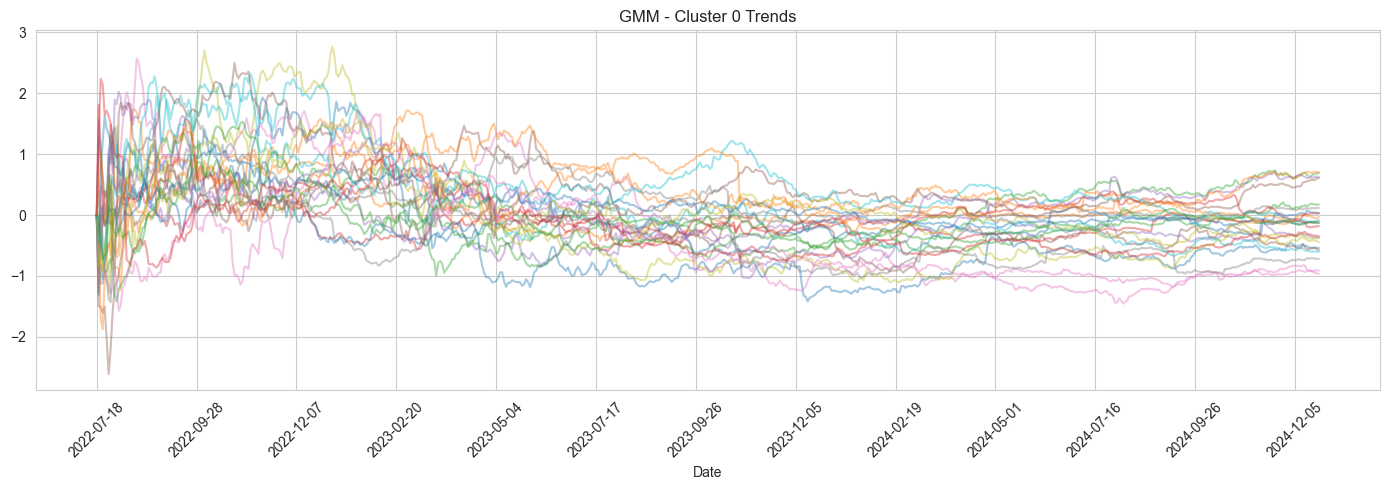

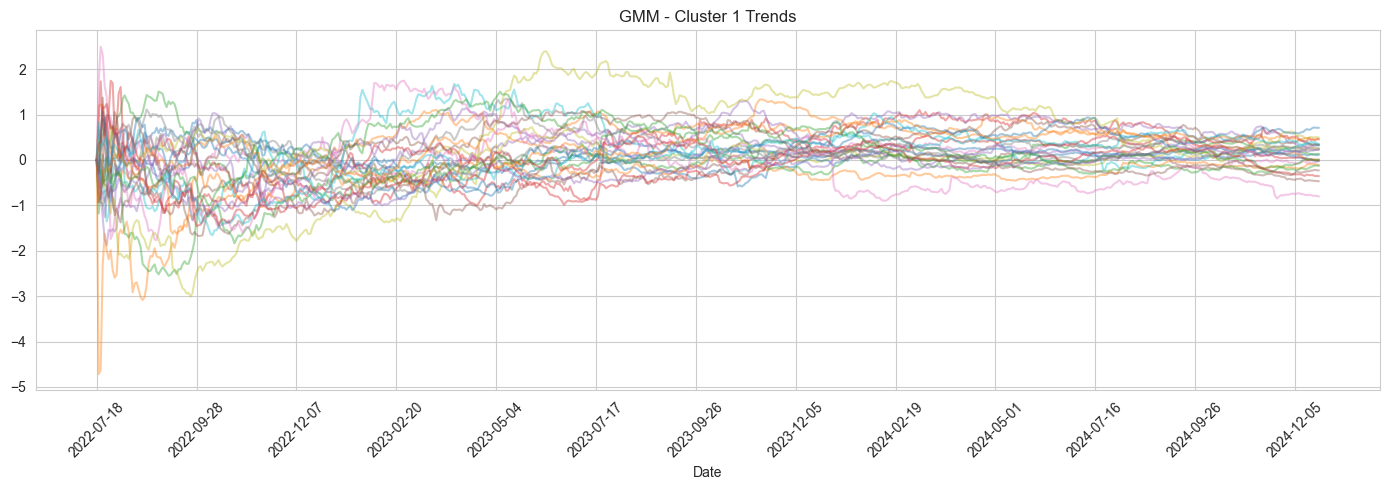

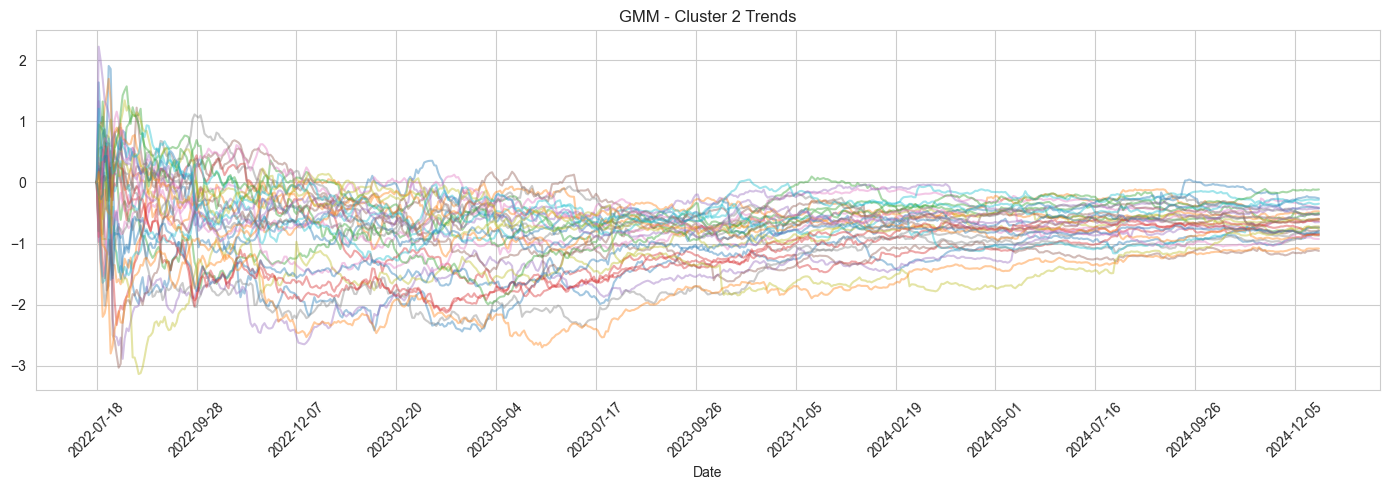

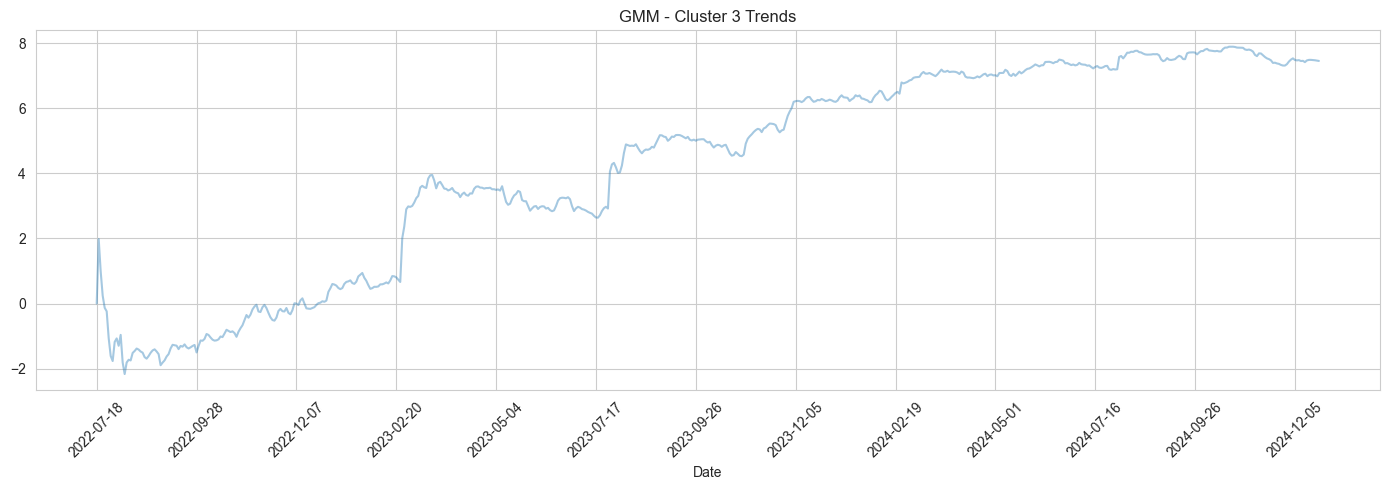

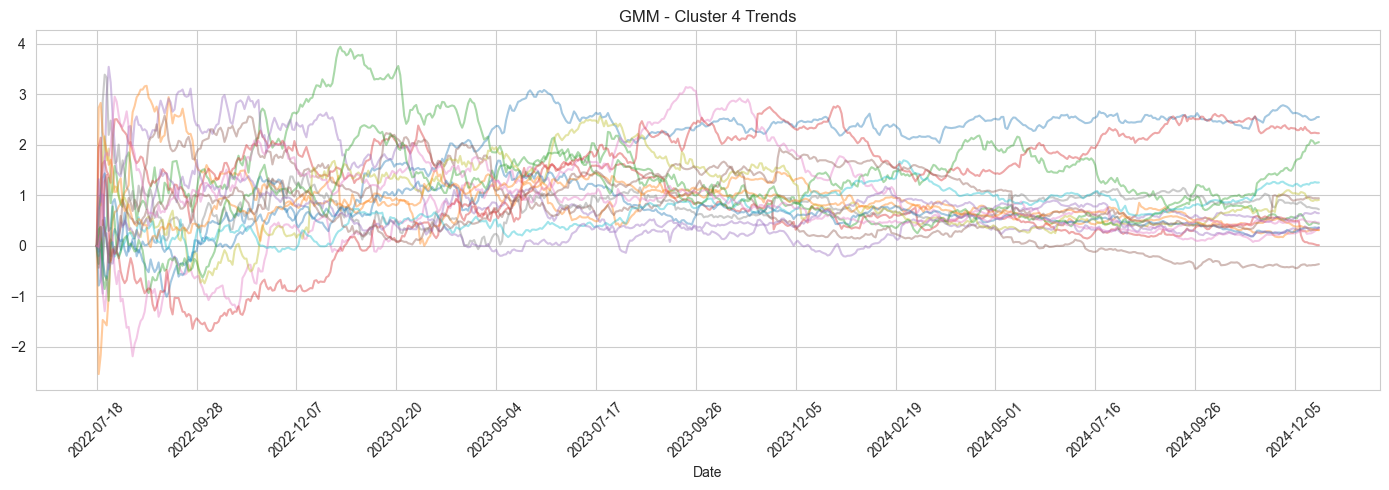

In [8]:
# Example: Visualize KMeans clusters
plot_clusters_trend(df, gmm.predict(df), "GMM")

# Birch

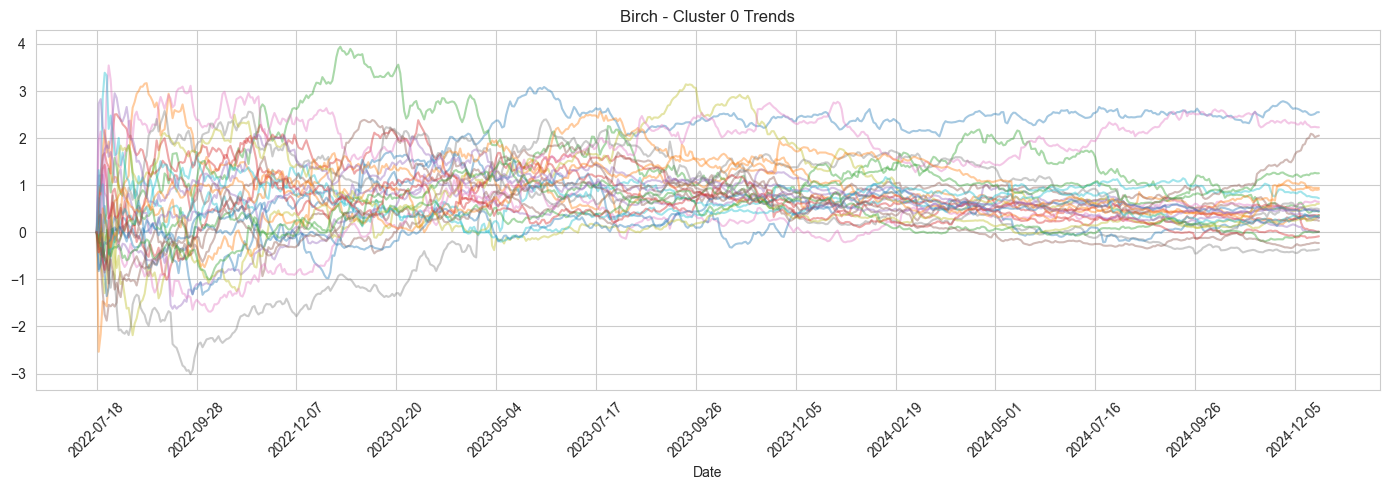

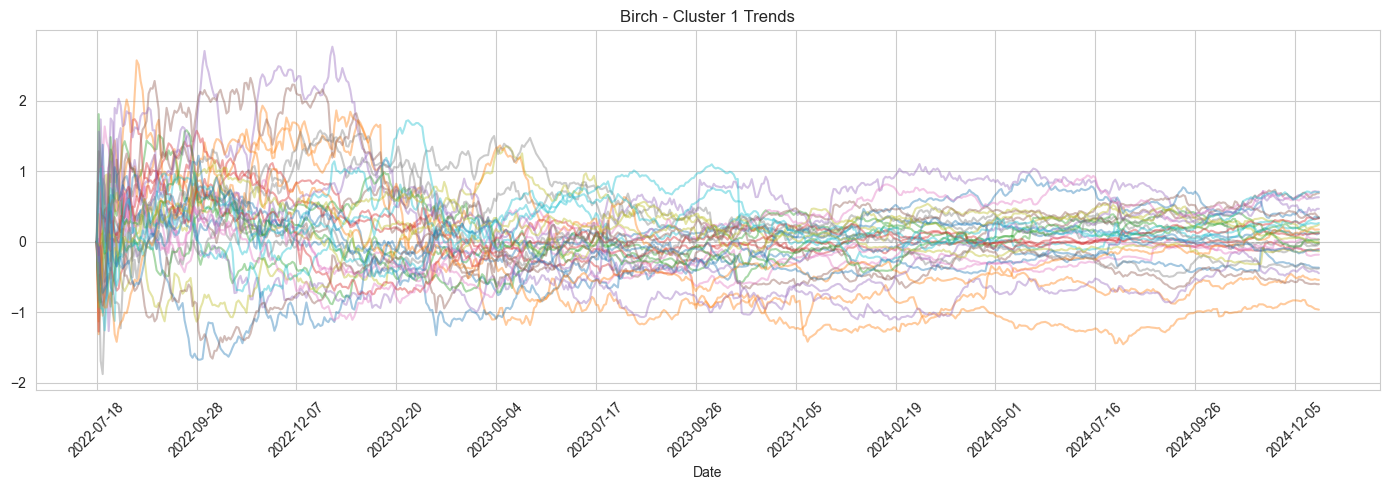

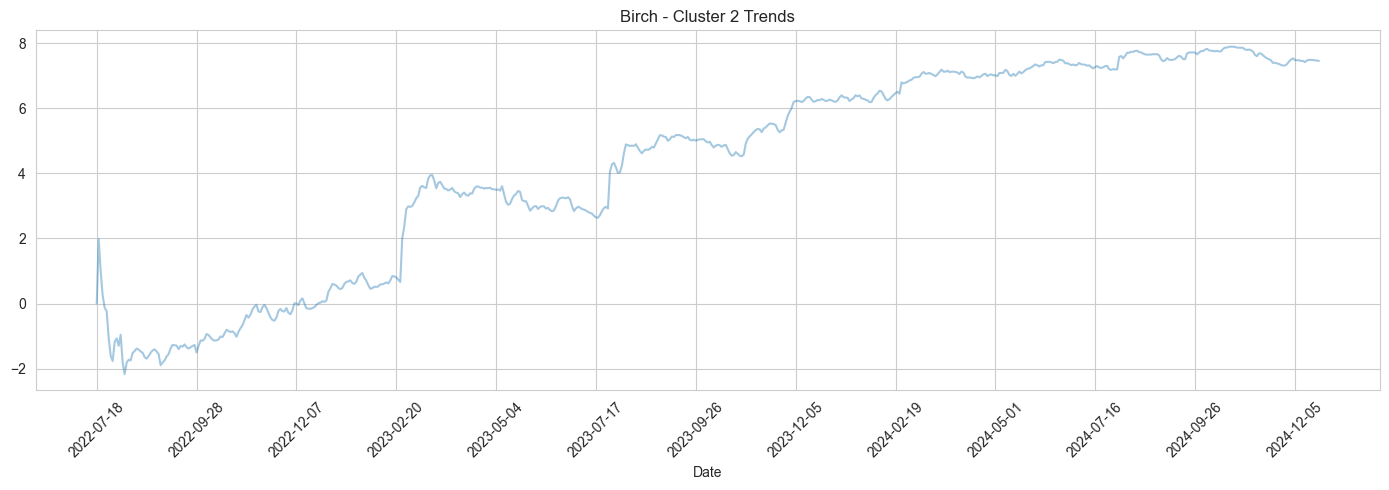

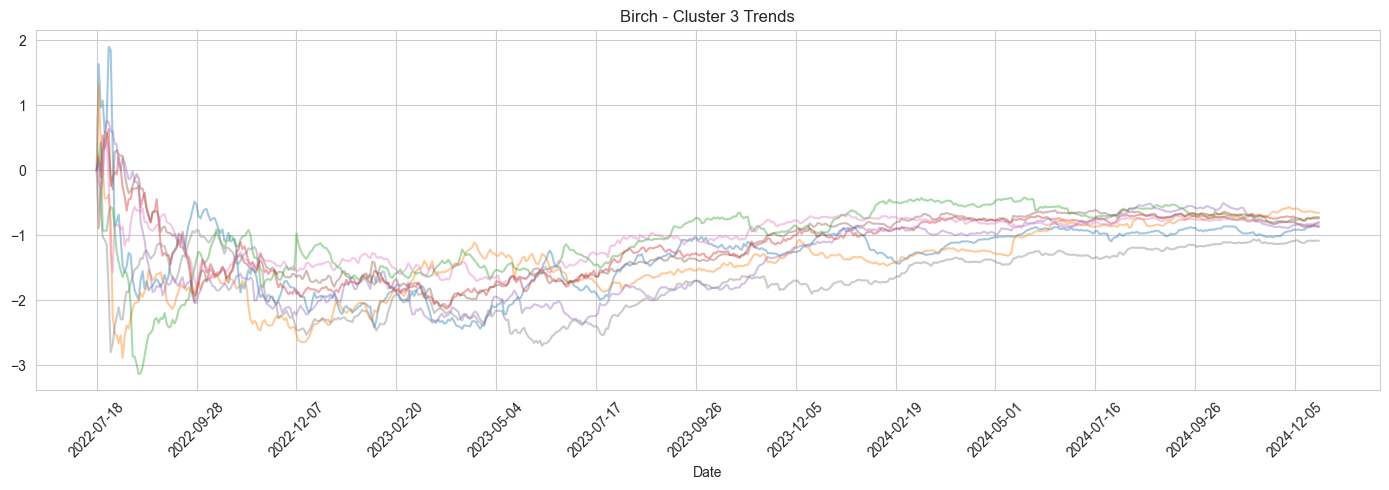

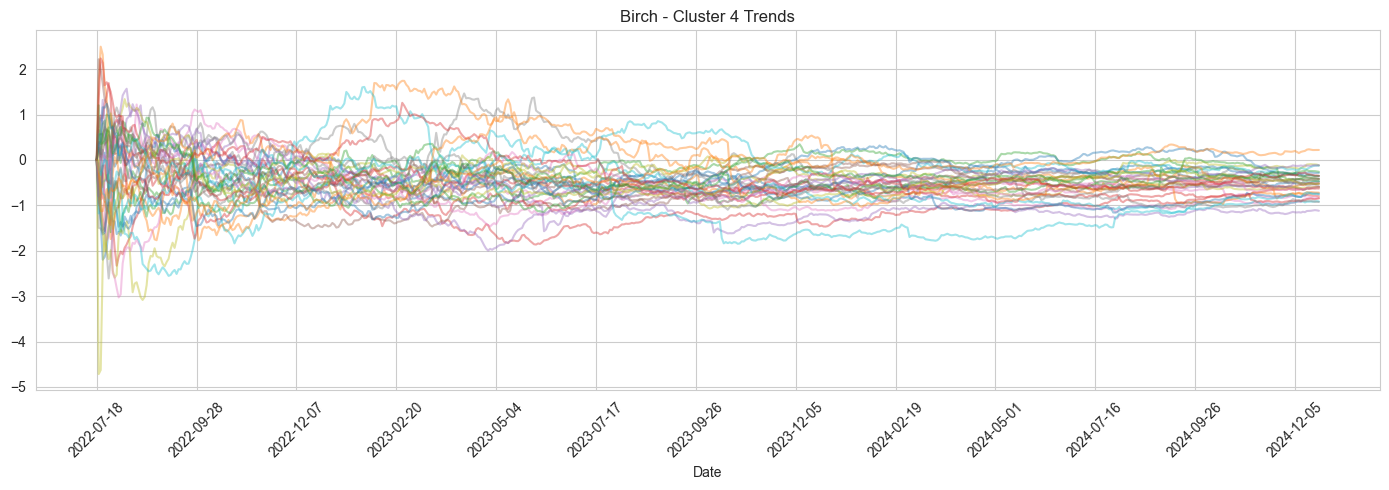

In [9]:
# Example: Visualize KMeans clusters
plot_clusters_trend(df, birch.labels_, "Birch")

In [10]:
from sklearn.manifold import TSNE
import umap.umap_ as umap

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(df)

umap_model = umap.UMAP(random_state=42)
X_umap = umap_model.fit_transform(df)

def plot_clusters_2D(X_proj, labels, method_name, reduction="t-SNE"):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_proj[:, 0], y=X_proj[:, 1], hue=labels, palette='tab10', s=30)
    plt.title(f'{method_name} Clusters Visualized with {reduction}')
    plt.grid(True)
    plt.show()

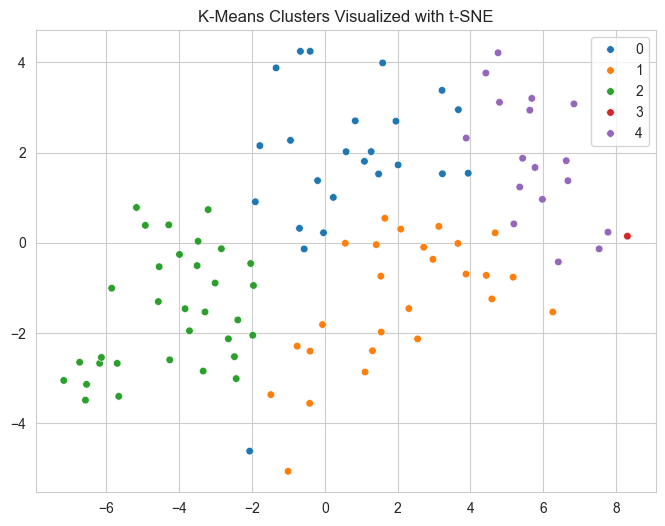

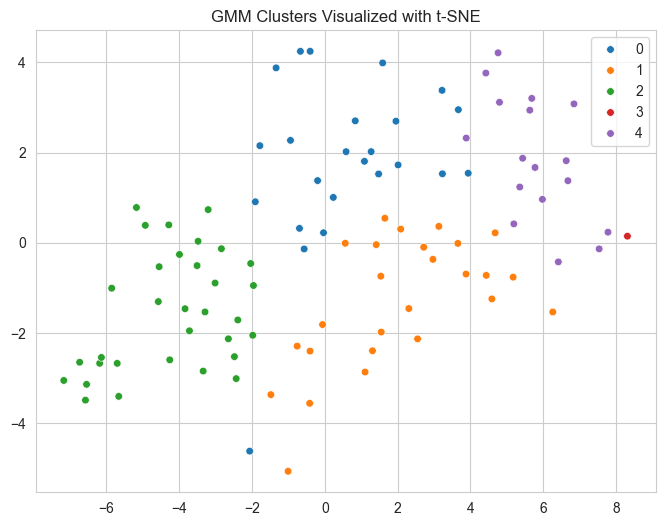

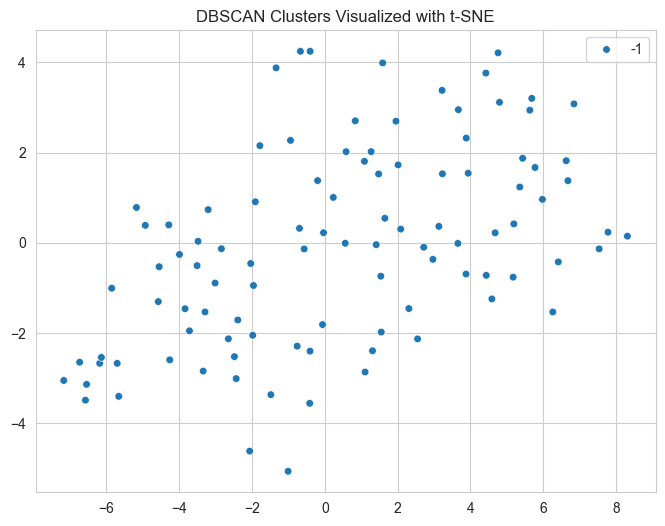

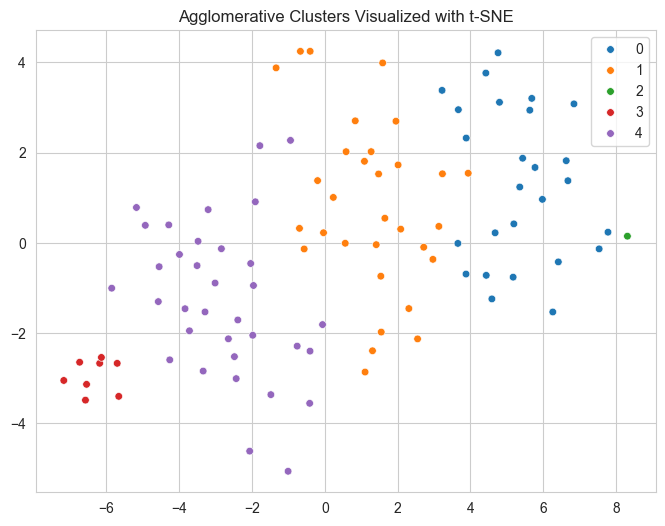

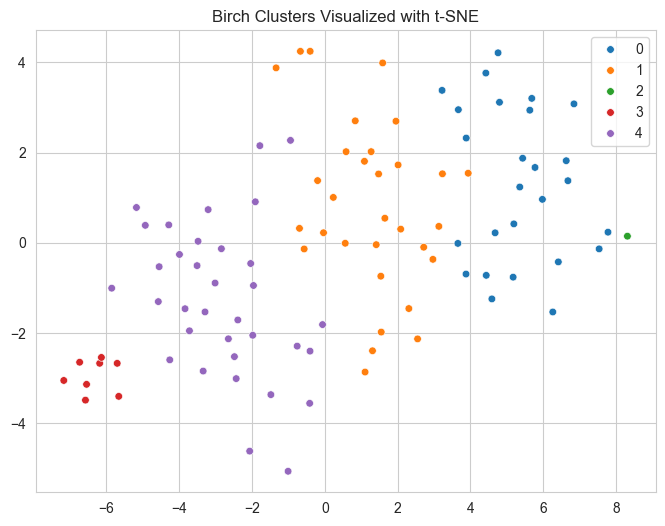

In [11]:
plot_clusters_2D(X_tsne, kmeans.labels_, "K-Means", "t-SNE")
plot_clusters_2D(X_tsne, gmm.predict(df), "GMM", "t-SNE")
plot_clusters_2D(X_tsne, dbscan.labels_, "DBSCAN", "t-SNE")
plot_clusters_2D(X_tsne, agglo.labels_, "Agglomerative", "t-SNE")
plot_clusters_2D(X_tsne, birch.labels_, "Birch", "t-SNE")

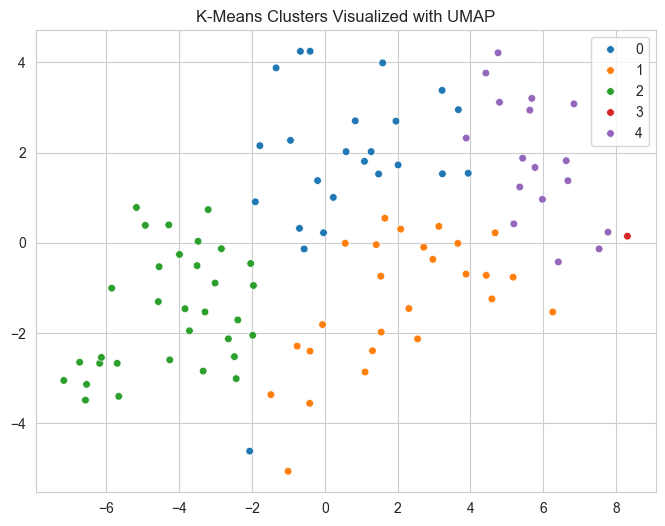

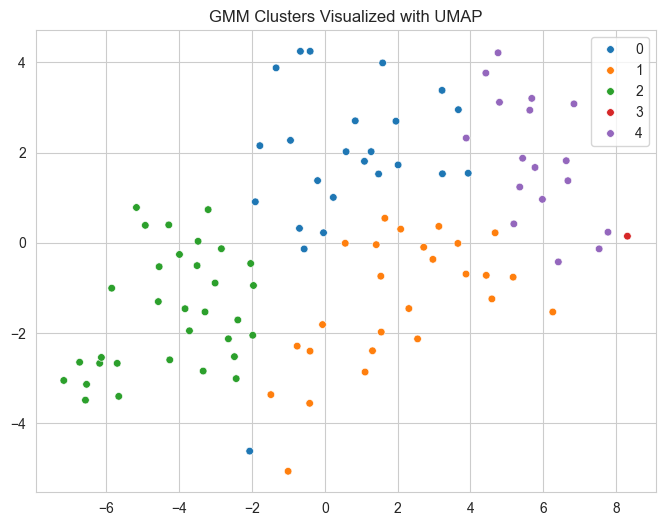

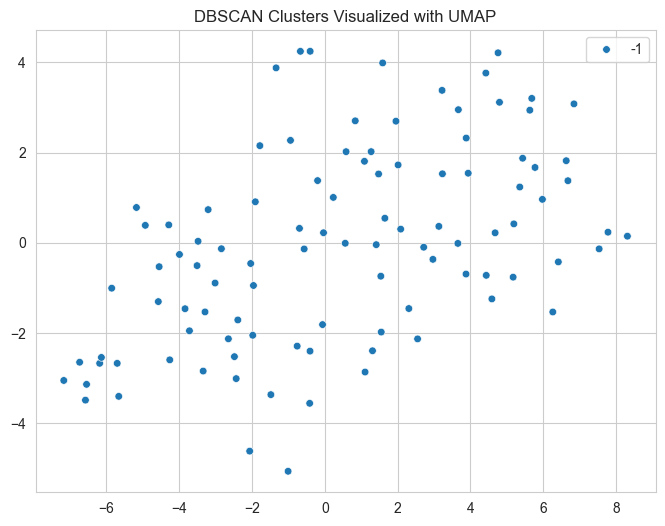

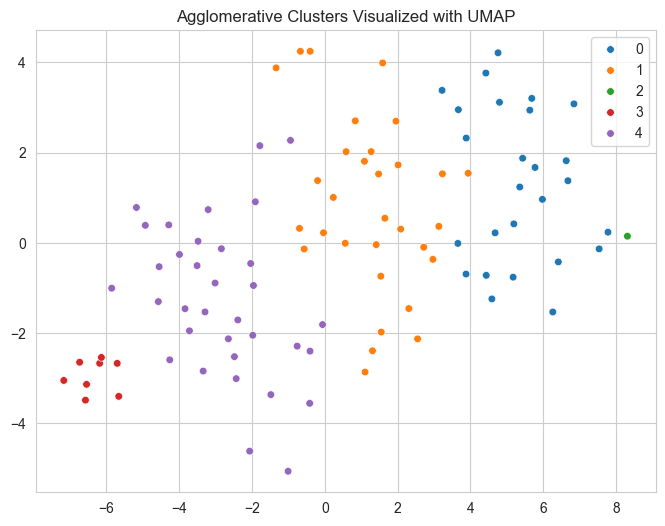

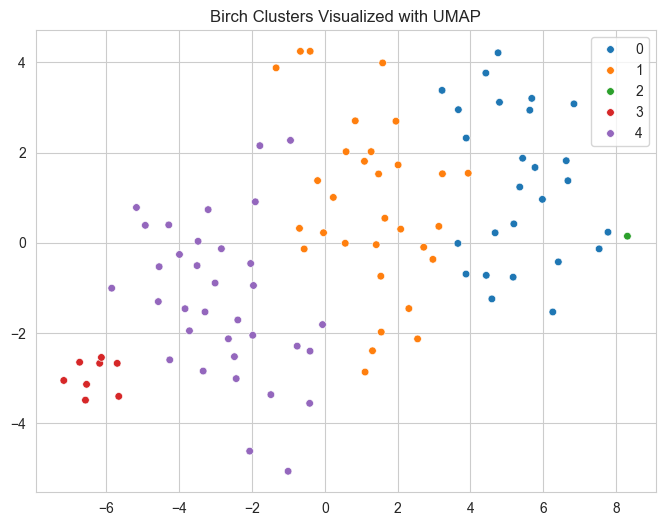

In [12]:
plot_clusters_2D(X_tsne, kmeans.labels_, "K-Means", "UMAP")
plot_clusters_2D(X_tsne, gmm.predict(df), "GMM", "UMAP")
plot_clusters_2D(X_tsne, dbscan.labels_, "DBSCAN", "UMAP")
plot_clusters_2D(X_tsne, agglo.labels_, "Agglomerative", "UMAP")
plot_clusters_2D(X_tsne, birch.labels_, "Birch", "UMAP")